In [2]:
import pandas as pd
import numpy as np
import re
import string 
import folium
import os
#from fuzzywuzzy import fuzz
#from fuzzywuzzy import process
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [4]:
# Load CSV
data = pd.read_csv(r'DataAnalyst.csv', index_col = 0)

In [6]:
data.head(5)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


##### Cleaning "Company Name" column to remove unnecessary characters

In [7]:
data["Company Name"] = data["Company Name"].str.replace('[0-9]','') # Removes all the numerics
data["Company Name"] = data["Company Name"].str.replace('.','') # Removes all the dots

#### Similarly cleaning other columns having unnecessary data

In [8]:
# Data Cleaning
data["Size"] = data["Size"].replace('-1','unknown')
data["Founded"] = data["Founded"].replace(-1,'unknown')
data["Type of ownership"] = data["Type of ownership"].replace('-1', 'unknown')
data["Industry"] = data["Industry"].replace('-1', 'unknown')
data["Sector"] = data["Sector"].replace('-1','unknown')
data["Revenue"] = data["Revenue"].replace('-1','unknown')
data["Competitors"] = data["Competitors"].replace('-1','unknown')
data["Easy Apply"] = data["Easy Apply"].replace('-1','unknown')
x = data["Easy Apply"].value_counts()

#### The "Salary Estimate" column has start amount and last amount as a salary range in the same column so that needs to be split into two different columns. Also cleaning the column keeping only numeric data.

In [14]:
pd.DataFrame(data["Salary Estimate"].head(5))

,Salary Estimate
0,$37K-$66K (Glassdoor est.)
1,$37K-$66K (Glassdoor est.)
2,$37K-$66K (Glassdoor est.)
3,$37K-$66K (Glassdoor est.)
4,$37K-$66K (Glassdoor est.)


In [16]:
# Creating Salary columns
data[["Start_amount", "Last_amount"]] = data["Salary Estimate"].str.split("-", expand=True)
data["Start_amount"] = data['Start_amount'].str.extract(r"(\d+)", expand=True).astype(float)
data["Last_amount"] = data['Last_amount'].str.extract(r"(\d+)", expand=True).astype(float)
data[["Start_amount", "Last_amount"]]

,Start_amount,Last_amount
0,37.0,66.0
1,37.0,66.0
2,37.0,66.0
3,37.0,66.0
4,37.0,66.0
...,...,...
2248,78.0,104.0
2249,78.0,104.0
2250,78.0,104.0
2251,78.0,104.0


#### Creating "Salary_avg" column to store average of the salary for each job category

In [19]:
data['Salary_avg'] = (data['Start_amount']+data["Last_amount"])/2
data["Salary_avg"]

0       51.5
1       51.5
2       51.5
3       51.5
4       51.5
        ... 
2248    91.0
2249    91.0
2250    91.0
2251    91.0
2252    91.0
Name: Salary_avg, Length: 2253, dtype: float64

#### Analysing the job salary based on location. This are statistical analysis which can help employer set a salary range for new opening.

In [20]:
#Data Analysis based on location
location_group = pd.DataFrame(data[['Location','Salary_avg']].groupby(by = 'Location').agg(['mean', 'std','min', 'max','count'])).reset_index()

location_group.columns = ['location', 'mean', 'std','min', 'max','count'] # Naming the aggregate function columns
location_group

,location,mean,std,min,max,count
0,"Addison, TX",63.500000,NaN,63.5,63.5,1
1,"Alachua, FL",42.000000,NaN,42.0,42.0,1
2,"Alameda, CA",60.500000,NaN,60.5,60.5,1
3,"Alhambra, CA",56.500000,23.334524,40.0,73.0,2
4,"Allegheny West, PA",56.000000,21.920310,40.5,71.5,2
...,...,...,...,...,...,...
248,"Woodbridge, NJ",106.000000,NaN,106.0,106.0,1
249,"Woodcliff Lake, NJ",72.000000,NaN,72.0,72.0,1
250,"Woodland Hills, CA",91.416667,34.749700,54.0,122.5,6
251,"Woodridge, IL",68.250000,13.081475,59.0,77.5,2


#### Categorizing the jobs based on job description column

In [21]:
# Creating Job category for every Job type
stopworddict = dict({'Business Analyst':['business'],
                'Health Care Data Analyst':['health', 'clinical', 'pharma','pharmacy'],
                'Marketing Data Analyst':['marketing', 'market'],
                'Financial Data Analyst':['finance', 'financial'],
                'Data Scientist':['science', 'scientist','scientistresearch'],
                'Junior Data Analyst':['jr','jr.', 'junior', 'entry','intern','internship'],
                'Senior Data Analyst':['sr', 'sr.', 'senior'],
                'Data Analyst':['data','analyst']})

data['Job_split'] = [re.sub('['+string.punctuation+']', '',i.lower()).split() for i in data['Job Title']]

df = []

for i in data['Job_split']:     #
    for dkey,dvalue in stopworddict.items():
        if any( v1 in i for v1 in dvalue) == True:
            break
    df.append(dkey)

data['Job_category'] = df 
data.Job_category

0              Data Analyst
1              Data Analyst
2       Senior Data Analyst
3              Data Analyst
4              Data Analyst
               ...         
2248           Data Analyst
2249    Senior Data Analyst
2250       Business Analyst
2251           Data Analyst
2252    Senior Data Analyst
Name: Job_category, Length: 2253, dtype: object

#### Creating dataframe ready to use for Machine Learning model to predict average salary based on location and job category

In [24]:
# Creating dataframe for the model
df_reg = pd.DataFrame(data[['Location','Salary_avg','Job_category']].groupby(by = ['Location','Job_category']).agg(['mean'])).reset_index()
df_reg.columns = ['locations','job_category','average_salary']

In [25]:
# splitting into x and y
X = df_reg[['locations','job_category']]
y = df_reg['average_salary']


#### We need to onehotencode  location and job_category column before passing it into machine learning model

In [26]:
# onehotencoding
X = pd.concat([pd.get_dummies(X[col]) for col in X], axis=1, keys=X.columns)

X.columns = [value for key,value in X.columns]   # naming onhotencoded columns


#### Splitting train and testing data

In [28]:
# train test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


#### Fitting and predicting the OLS Regression model

In [29]:
# Regression model
model = sm.OLS(y_train, X_train).fit()  # training model
predictions = model.predict(X_test) # make the predictions by the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         average_salary   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     3.957
Date:                Thu, 29 Apr 2021   Prob (F-statistic):           2.34e-16
Time:                        12:42:27   Log-Likelihood:                -1212.0
No. Observations:                 350   AIC:                             2856.
Df Residuals:                     134   BIC:                             3689.
Df Model:                         215                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Addison, TX                     -5.545e-15   5.63e-15     -0.984      0.327   -1.67e-14     5.6e-15
Alachua, FL                       -26.0821     12.473     -2.091      0.038     -50.752      -1.412
Alameda, CA                     -1.853e-13    9.1e-14     -2.037      0.044   -3.65e-13   -5.39e-15
Alhambra, CA                      -13.5956     12.599     -1.079      0.282     -38.514      11.323
Allegheny West, PA                -13.0888      8.850     -1.479      0.141     -30.592       4.414
Allen, TX                         -11.0821     12.473     -0.888      0.376     -35.752      13.588
American Fork, UT                 -31.5821     12.473     -2.532      0.012     -56.252      -6.912
Anaheim, CA                         0.8346     12.473      0.067      0.947     -23.835      25.504
Arcadia, CA                        52.4044     12.599      4.159      0.000      27.486      77.323
Arlington Heights, IL           -2.187e-14   1.67e-14     -1.308      0.193    -5.5e-14    1.12e-14
Arlington, TX                     -14.5521      7.290     -1.996      0.048     -28.970      -0.134
Athens, GA                        -24.0821     12.473     -1.931      0.056     -48.752       0.588
Aurora, CO                       3.431e-14   1.87e-14      1.833      0.069   -2.72e-15    7.13e-14
Austin, TX                         -7.1412      7.254     -0.984      0.327     -21.488       7.205
Azusa, CA                           4.9179     12.473      0.394      0.694     -19.752      29.588
Beech Grove, IN                   -22.5956     12.599     -1.793      0.075     -47.514       2.323
Bellevue, WA                      -17.0821     12.473     -1.370      0.173     -41.752       7.588
Bensalem, PA                    -5.403e-14   4.85e-14     -1.113      0.268    -1.5e-13     4.2e-14
Berkeley Heights, NJ             1.572e-14   1.97e-14      0.798      0.426   -2.33e-14    5.47e-14
Berkeley, CA                       47.4179     12.473      3.802      0.000      22.748      72.088
Berwyn, PA                        -27.5821     12.473     -2.211      0.029     -52.252      -2.912
Beverly Hills, CA                  -2.0888      8.850     -0.236      0.814     -19.592      15.414
Blue Bell, PA                     -10.5956     12.599     -0.841      0.402     -35.514      14.323
Boothwyn, PA                       20.4179     12.473      1.637      0.104      -4.252      45.088
Boulder, CO                       -12.0521     13.178     -0.915      0.362     -38.117      14.013
Brea, CA                          -28.0821     12.473     -2.251      0.026     -52.752      -3.412
Bridgeview, IL                     -9.0821     12.473     -0.728      0.468     -33.752      15.588
Broadview, IL                     -15.0521     13.178     -1.142      0.255     -41

In [17]:
# Printing Regression model statistics
from sklearn import metrics
print(metrics.mean_absolute_error(y_test, predictions))
print(metrics.mean_squared_error(y_test, predictions))
print(np.sqrt(metrics.mean_squared_error(y_test, predictions)))

14.644740246387125
369.1650055234176
19.21366715448713


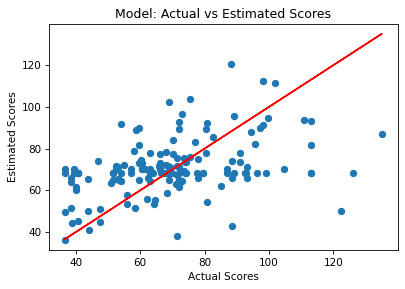

In [30]:
# Plotting Regression line
plt.figure(dpi = 75)
plt.scatter(y_test, predictions)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Actual Scores")
plt.ylabel("Estimated Scores")
plt.title("Model: Actual vs Estimated Scores")
plt.show()


In [20]:
# Creating location wise data summery 
location_summary = df_reg.pivot(index = 'locations', columns = 'job_category', values = 'average_salary' )
location_summary

job_category,Business Analyst,Data Analyst,Data Scientist,Financial Data Analyst,Health Care Data Analyst,Junior Data Analyst,Marketing Data Analyst,Senior Data Analyst
locations,,,,,,,,
"Addison, TX",NaN,63.500000,NaN,NaN,NaN,NaN,NaN,NaN
"Alachua, FL",NaN,42.000000,NaN,NaN,NaN,NaN,NaN,NaN
"Alameda, CA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.5
"Alhambra, CA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.5
"Allegheny West, PA",NaN,40.500000,NaN,NaN,NaN,NaN,NaN,71.5
...,...,...,...,...,...,...,...,...
"Woodbridge, NJ",106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Woodcliff Lake, NJ",NaN,NaN,NaN,NaN,72.00,NaN,NaN,NaN
"Woodland Hills, CA",NaN,99.666667,NaN,NaN,97.75,54.0,NaN,NaN


#### Creating geoplot to plot average salaries based on US states

In [ ]:
# Creating Geoplot

location_group['states'] = location_group['location'].str.rsplit(' ')
location_group['states'] = [ i[-1] for i in location_group['states']]

state_geo = os.path.join('us-states.json')

# Initialize the map:
l = folium.Map(location=[37, -102], zoom_start=5)
 
# Add the color for the chloropleth:
l.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=location_group,
 columns=['states', 'mean'],
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Average Salary (%)'
)
folium.LayerControl().add_to(l)

l.save('avgsalvsstate.html')